In [1]:
import sys
import pathlib
cwd = pathlib.Path().cwd()
sys.path.append(cwd.parent.as_posix())
data_folder = cwd.parent.joinpath('data')

import pickle
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from functools import partial
from sklearn.metrics import f1_score

In [2]:
# calc proba
model = pickle.load(open('model.pkl', 'rb'))

# select part of train
train = pd.read_csv(data_folder.joinpath('data_train.csv')).drop('Unnamed: 0', axis=1)
train = train[train['buy_time'] >= dt.datetime.fromisoformat('2018-11-19').timestamp()]

data = train.drop('target', axis=1)
target = train['target']

proba = model.predict_proba(data)

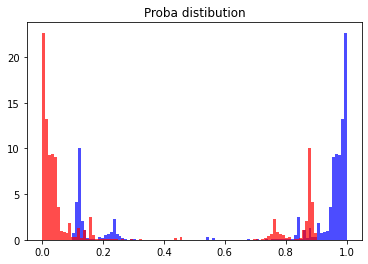

In [3]:
# proba distribution figure
plt.title('Proba distibution')
plt.hist(proba.T[0], bins=100, color='blue', alpha=0.7, density=True);
plt.hist(proba.T[1], bins=100, color='red', alpha=0.7, density=True);

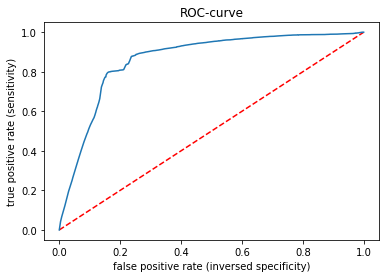

In [4]:
fpr, tpr, thr = roc_curve(target, proba.T[1])
plt.title('ROC-curve')
plt.xlabel('false positive rate (inversed specificity)')
plt.ylabel('true positive rate (sensitivity)')
plt.plot([0, 1], [0, 1], '--', color='red')
plt.plot(fpr, tpr);

Видны две потенциально интересные точки.

In [5]:
idx = [None, None]

In [6]:
# находим оптимальный threshold - с max(tpr) и min(fpr)
idx[0] = ((fpr + 1) / (tpr + 1)).argmin()
print(f'sensitivity = {tpr[idx[0]]}', f'specificity = {1 - fpr[idx[0]]}', f'threshold = {thr[idx[0]]}', sep='\n')
print(f1_score(target, (proba.T[1] >= thr[idx[0]]) * 1, average='macro'))

sensitivity = 0.7952612089671738
specificity = 0.8414631628924716
threshold = 0.20298335931356296
0.737274388875321


In [7]:
# или по ср.геометрическому
idx[1] = np.sqrt(tpr * (1 - fpr)).argmax()
print(f'sensitivity = {tpr[idx[1]]}', f'specificity = {1 - fpr[idx[1]]}', f'threshold = {thr[idx[1]]}', sep='\n')
print(f1_score(target, (proba.T[1] >= thr[idx[1]]) * 1, average='macro'))

sensitivity = 0.8767013610888711
specificity = 0.7638585554156432
threshold = 0.09017326150619004
0.69316577812213


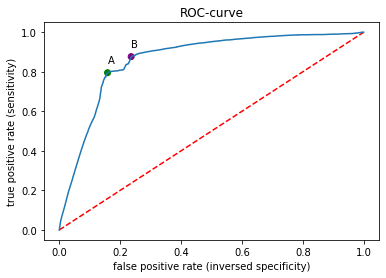

In [8]:
fpr, tpr, thr = roc_curve(target, proba.T[1])
fig, ax = plt.subplots()
plt.title('ROC-curve')
plt.xlabel('false positive rate (inversed specificity)')
plt.ylabel('true positive rate (sensitivity)')
plt.plot([0, 1], [0, 1], '--', color='red')
plt.plot(fpr, tpr);
ax.scatter(fpr[idx], tpr[idx], c=['green', 'purple'],)
for n, i in enumerate(list(idx)):
    ax.annotate(chr(65 + n), [fpr[i], tpr[i] + 0.05])

Да, финальная метрика может быть ниже, но результат оптимальнее.<br>
Точка А соответствует меньшей способности обнаружить потенциального покупателя, но большей - не ошибиться в выборе.<br>
Точка B, наоборот, соответствует большей способности обнаружить потенциальных покупателей, но меньшей - сделать это правильно.

## tmp

In [ ]:
# функция метрики от выбранного threshold
def thr_metric_func(threshold, *, y_true, proba):
    return f1_score(y_true, (proba >= threshold) * 1, average='macro')

thr_metric = np.vectorize(partial(thr_metric_func, y_true=target, proba=proba.T[1]))

In [ ]:
thr_metric(np.linspace(0.45, 0.55, 5))

In [ ]:
#